# Task 1

In [1]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt
import scipy

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.5.1+cu121
0.20.1+cu121


In [2]:
from sklearn.datasets import fetch_openml

images, labels = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int) 

In [3]:
print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


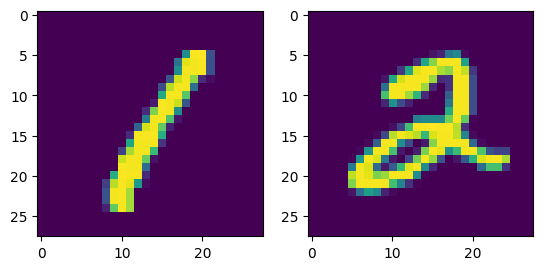

In [4]:
dataset = images[np.logical_or(labels == 1,labels == 2)]
target = labels[np.logical_or(labels == 1,labels == 2)]

plt.subplot(1,2,1)
plt.imshow(dataset[0].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(dataset[1].reshape((28,28)))

In [5]:
angles = np.arange(0, 360, 30)
angle_count = len(angles)

In [6]:
def rotate_image(image, angle):
    # Rotate the image using scipy
    rotated = scipy.ndimage.rotate(image.reshape((28,28)), angle, reshape=False, mode='constant', cval=0)
    # Ensure the dtype is maintained as uint8
    return np.clip(rotated, 0, 255).astype(np.uint8)

In [7]:
data_len = len(dataset)


dataset_rotated = np.zeros((data_len, angle_count, 28, 28), dtype=np.uint8)
target_rotated = np.zeros((data_len, angle_count), dtype=np.uint8)

In [8]:
for i, image in enumerate(dataset):
    for j, angle in enumerate(angles):
        dataset_rotated[i][j] = rotate_image(image, angle)
        target_rotated[i][j] = target[i]

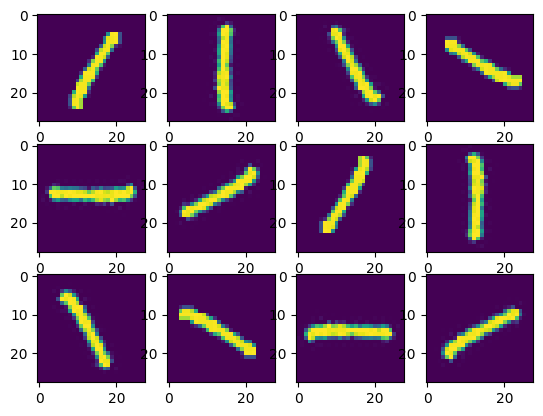

In [9]:
for i in range(len(dataset_rotated[0])):
    plt.subplot(3,4,i+1)
    plt.imshow(dataset_rotated[0][i])

In [10]:
data_norm = dataset_rotated / 255.

In [11]:
np.savez("data.npz", data_norm=data_norm, target_rotated=target_rotated)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data_norm, target_rotated, test_size=0.2, shuffle=True, random_state=12345)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(11893, 12, 28, 28)
(11893, 12)
(2974, 12, 28, 28)
(2974, 12)


In [13]:
X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()


batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

In [38]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(1, hidden_channels, kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*2,kernel_size=3, stride=2, padding=1) 

        self.conv3 = nn.Conv2d(hidden_channels*2, hidden_channels*4, kernel_size=3, stride=2, padding=1)

        self.fc1 = nn.Linear(4096, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, int(hidden_channels/2))
        
        self.fc_mu = nn.Linear(in_features=int(hidden_channels/2),
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=int(hidden_channels/2),
                                   out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))

        x = x.view(x.shape[0], -1) #flatten
    
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        
        x_mu = self.fc_mu(x)

        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.conv1 = nn.ConvTranspose2d(hidden_channels, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv2 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels,kernel_size=3, stride=2, padding=1, output_padding=1) 

        self.conv3 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, kernel_size=3, stride=2, padding=1)

        self.fc1 = nn.Linear(hidden_channels, 4096)
        self.fc2 = nn.Linear(int(hidden_channels/2), hidden_channels )

        self.fc = nn.Linear(latent_dim, int(hidden_channels/2))


        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.activation(self.fc(x))
        
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc1(x))
        
        
        x = x.view(x.size(0), self.hidden_channels*4, 4, 4)
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

# Full VAE/AE Model

use_VAE = True #False: AE, True: VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)

        #VAE/AE
        if use_VAE:
          z = self.latent_sample(latent_mu, latent_logvar)
        else:
          z = latent_mu

        x_recon = self.decoder(z)

        # ritorna x ricostruito, mu, e logvar
        return x_recon, latent_mu, latent_logvar

    # sampling function (implementa il reparametrization trick)
    def latent_sample(self, mu, logvar):

        if self.training: #true se si è in training mode
          #campioniamo z(input decoder) da G(mu, sigma)
          sigma = (0.5*logvar).exp()
          z = mu + sigma * torch.randn_like(sigma)
          return z

        else:
          return mu

In [15]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla P100-PCIE-16GB
Computation device: cuda



In [39]:

hidden_channels = 64
latent_dim = 16 

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)

print(model_vae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_vae.cuda(), input_size=(1,28,28))
else:
  summary(model_vae, input_size=(1,28,28))

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=64, out_features=4096, bias=True)
    (fc2): Linear(in_features=32, out_features=64

In [17]:
# testiamo il modello su un batch

model_vae.to(device)

model_vae.eval()

x,_ = next(iter(train_dl))

for i in range(angle_count):
    x_rot = x[:, i]
    x_rot = torch.reshape(x_rot, [len(x_rot),1,28,28])

    x_rot =x_rot.to(device)

    xtilde,mu,logv = model_vae(x_rot)

print(mu.shape)
print(xtilde.shape)

torch.Size([128, 16])
torch.Size([128, 1, 28, 28])


In [44]:
beta_par = 4.

# VAE loss
def vae_loss(recon_x, x, mu, logvar):

  recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

  if use_VAE:
    # closed form of KL divergence for normal priors: (-1/2 sum (1 + log sigma^2 - mu^2 - sigma^2))
      
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  else:
    kldivergence = 0.0

  return recon_loss + beta_par * kldivergence, recon_loss, beta_par * kldivergence

In [19]:
# Training

hidden_channels = 64
latent_dim = 16 

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)

model_vae = model_vae.to(device)


# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_vae.parameters(), lr=LR, weight_decay=1e-5)

In [20]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            #print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"Saving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
                }, 'vae_model.pth')

In [21]:
import time

save_best_model = SaveBestModel() #initialize checkpoint function

epochs = 30
hist_loss = []
hist_kloss = []
hist_rloss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_vae.train()
    train_loss = 0.
    train_rloss = 0.
    train_kloss = 0.
    counter = 0

    for xb, _ in train_dl:
        for i in range(angle_count):
            counter += 1
            x_rot = xb[:, i]
            x_rot = torch.reshape(x_rot, [len(x_rot),1,28,28])

            x_rot =x_rot.to(device)

            recon_x, mu, logvar = model_vae(x_rot)


            loss, rloss, kloss = vae_loss(recon_x, x_rot, mu, logvar)

            train_loss += loss.item()
            train_rloss += rloss.item()
            train_kloss += kloss.item()

            # backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()


    train_loss /= counter
    train_rloss /= counter
    train_kloss /= counter

    hist_loss.append(train_loss)
    hist_rloss.append(train_rloss)
    hist_kloss.append(train_kloss)

    save_best_model(train_loss, epoch, model_vae, opt, vae_loss)

    # aggiungere la parte su validation usando il test set

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.2f, train loss: %.2f, train reco loss: %.2f, train kl loss: %.2f"
          % (epoch+1, elapsed_time, train_loss, train_rloss, train_kloss))

epoch: 1, time(s): 6.90, train loss: 24761.39, train reco loss: 23911.42, train kl loss: 849.97
epoch: 2, time(s): 6.63, train loss: 20586.51, train reco loss: 18585.27, train kl loss: 2001.24
epoch: 3, time(s): 6.65, train loss: 19950.89, train reco loss: 17708.46, train kl loss: 2242.44
epoch: 4, time(s): 6.66, train loss: 19186.10, train reco loss: 16642.20, train kl loss: 2543.90
epoch: 5, time(s): 6.59, train loss: 18796.63, train reco loss: 16124.62, train kl loss: 2672.01
epoch: 6, time(s): 6.65, train loss: 18568.49, train reco loss: 15827.10, train kl loss: 2741.39
epoch: 7, time(s): 6.59, train loss: 18462.50, train reco loss: 15659.13, train kl loss: 2803.36
epoch: 8, time(s): 6.59, train loss: 18340.44, train reco loss: 15498.03, train kl loss: 2842.41
epoch: 9, time(s): 6.67, train loss: 18223.64, train reco loss: 15356.59, train kl loss: 2867.06
epoch: 10, time(s): 6.59, train loss: 18205.30, train reco loss: 15310.83, train kl loss: 2894.47
epoch: 11, time(s): 6.66, trai

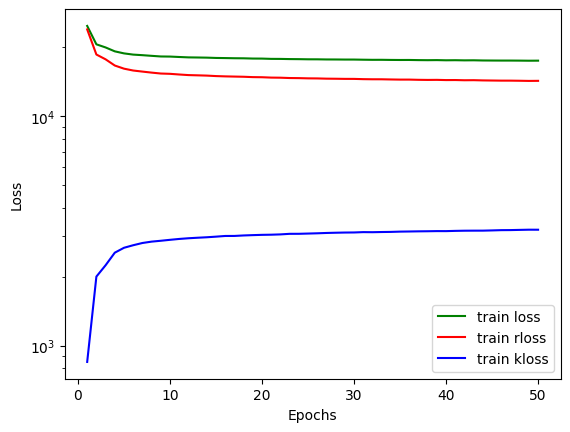

In [22]:
# training loss plot (aggiungere la parte sul test set)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_rloss)+1), hist_rloss, color='red', linestyle='-', label='train rloss')
plt.plot(range(1,len(hist_kloss)+1), hist_kloss, color='blue', linestyle='-', label='train kloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.show()

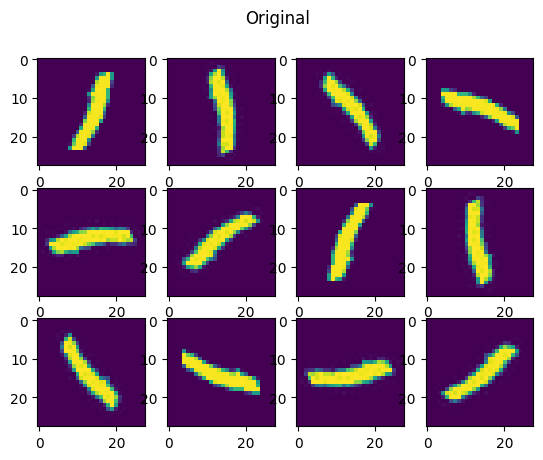

In [23]:
x,_ = next(iter(test_dl))
image = x[0]

plt.suptitle("Original")
for i in range(len(image)):
    plt.subplot(3,4,i+1)
    plt.imshow(image[i])    

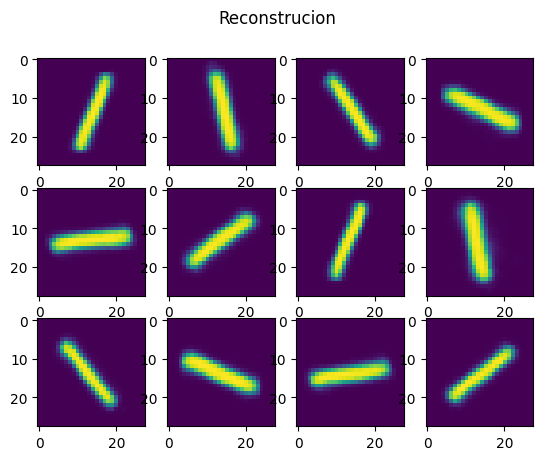

In [24]:
plt.suptitle("Reconstrucion")
with torch.no_grad():
    for i in range(angle_count):
        x_rot = x[:, i]
        x_rot = torch.reshape(x_rot, [len(x_rot),1,28,28])

        x_rot =x_rot.to(device)

        xtilde,_,_ = model_vae(x_rot)
        
        plt.subplot(3,4,i+1)
        plt.imshow(xtilde[0].reshape((28,28)).cpu())    

In [45]:
checkpoint = torch.load('./vae_model.pth', weights_only=False, map_location=torch.device('cpu'))
print('Best model at epoch: ', checkpoint['epoch'])

model_vae = VAE(encoder, decoder)
model_vae.load_state_dict(checkpoint['model_state_dict'])
model_vae.eval()

Best model at epoch:  49


VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=64, out_features=4096, bias=True)
    (fc2): Linear(in_features=32, out_features=64

In [26]:
dataset_pt = torch.Tensor(data_norm).float()
target_pt = torch.Tensor(target_rotated).int()

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_td = TensorDataset(dataset_pt, target_pt)
dataset_dl = DataLoader(dataset_td, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [27]:
encoded_dataset = np.empty(shape=(len(dataset_dl) * batch_size, angle_count, latent_dim))

with torch.no_grad():
  for idx, (xb, _) in enumerate(dataset_dl):
    for i in range(angle_count):
        x_rot = xb[:, i]
        x_rot = torch.reshape(x_rot, [len(x_rot),1,28,28])
        x_rot =x_rot.to(device)
        _, mu, _ = model_vae(x_rot)
        encoded_dataset[batch_size*idx:batch_size*(idx+1),i,:] = mu.cpu()

In [28]:
target_encoded = target_rotated[:len(encoded_dataset)]

In [29]:
np.savez("latent_space.npz", encoded_dataset=encoded_dataset, target_encoded=target_encoded)

# Task 2

In [30]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt
import scipy

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.5.1+cu121
0.20.1+cu121


In [31]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla P100-PCIE-16GB
Computation device: cuda



In [32]:
angles = np.arange(0, 360, 30)
angle_count = len(angles)

In [33]:
npzfile = np.load("/kaggle/working/latent_space.npz")
encoded_dataset = npzfile['encoded_dataset']
target_encoded = npzfile['target_encoded']

In [34]:
npzfile = np.load("/kaggle/working/data.npz")
data_norm = npzfile['data_norm']
target_rotated = npzfile['target_rotated']

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(encoded_dataset, target_encoded, test_size=0.2, shuffle=True, random_state=12345)
X_train, X_vali, Y_train, Y_vali = train_test_split(X_train, Y_train, test_size=0.25, shuffle=True, random_state=12345)


print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

(8908, 12, 16)
(8908, 12)
(2970, 12, 16)
(2970, 12)
(2970, 12, 16)
(2970, 12)


In [36]:
X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()


batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt)
vali_dl = DataLoader(dataset_vali, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

In [37]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLP, self).__init__()

    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, output_dim) #output layer

    self.relu = nn.ReLU() # relu function

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x) # oppure x = F.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    out = self.layer3(x)

    return out

In [38]:
model = MLP(input_dim=16, output_dim=16, hidden_dim=128)
model = model.to(device)
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,16))
else:
  summary(model, input_size=(1,16))

MLP(
  (layer1): Linear(in_features=16, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=16, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           2,176
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 16]           2,064
Total params: 20,752
Trainable params: 20,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [39]:
criterion = nn.MSELoss()

# ottmizzatore: usiamo per esempio Adam
from torch import optim
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr)

In [40]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"Saving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
                }, 'best_MLP.pth')

In [41]:
import time

save_best_model = SaveBestModel() #initialize checkpoint function


epochs = 100
hist_loss = []
hist_vloss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model.train()
    train_loss = 0.
    vali_loss = 0.
    
    
    counter = 0
    for xb, _ in train_dl:
        for i in range(angle_count):
            counter += 1
            x_rot = xb[:, i]
            
            if i == (angle_count - 1):
                y = xb[:, 0]
            else:
                y = xb[:, i+1]

            x_rot =x_rot.to(device)
            y = y.to(device)

            pred = model(x_rot)


            loss = criterion(pred, y)

            train_loss += loss.item()


            # backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()


    train_loss /= counter

    
    counter = 0
    model.eval()
    
    with torch.no_grad():
        for xb, _ in vali_dl:
            for i in range(angle_count):
                counter += 1
                x_rot = xb[:, i]
            
                if i == (angle_count - 1):
                    y = xb[:, 0]
                else:
                    y = xb[:, i+1]

                x_rot =x_rot.to(device)
                y = y.to(device)

                pred = model(x_rot)


                loss = criterion(pred, y)

                vali_loss += loss.item()


    
    vali_loss /= counter

    hist_loss.append(train_loss)
    hist_vloss.append(vali_loss)


    save_best_model(vali_loss, epoch, model, opt, criterion)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.5f, train loss: %.5f, vali loss: %.5f" 
          % (epoch+1, elapsed_time, train_loss, vali_loss))


Best validation loss: 0.021043755147822092
Saving best model for epoch: 1

epoch: 1, time(s): 1.35482, train loss: 0.03711, vali loss: 0.02104

Best validation loss: 0.015172188224243944
Saving best model for epoch: 2

epoch: 2, time(s): 1.22918, train loss: 0.01832, vali loss: 0.01517

Best validation loss: 0.013000212491665414
Saving best model for epoch: 3

epoch: 3, time(s): 1.23605, train loss: 0.01461, vali loss: 0.01300

Best validation loss: 0.011870326644714003
Saving best model for epoch: 4

epoch: 4, time(s): 1.22977, train loss: 0.01334, vali loss: 0.01187

Best validation loss: 0.010858138241177507
Saving best model for epoch: 5

epoch: 5, time(s): 1.31384, train loss: 0.01235, vali loss: 0.01086
epoch: 6, time(s): 1.26917, train loss: 0.01173, vali loss: 0.01182

Best validation loss: 0.0104784431210989
Saving best model for epoch: 7

epoch: 7, time(s): 1.25280, train loss: 0.01116, vali loss: 0.01048

Best validation loss: 0.01001756008464735
Saving best model for epoch

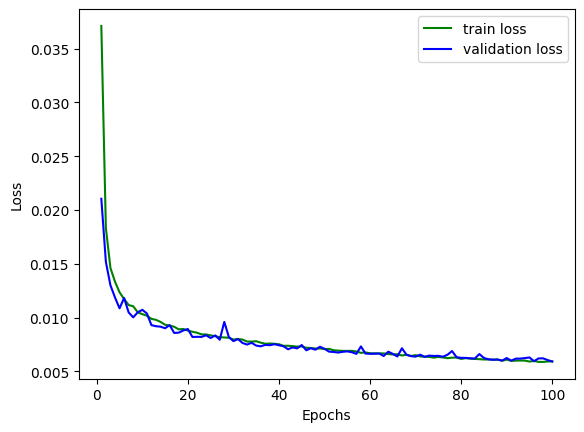

In [43]:
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [44]:
model = MLP(input_dim=16, output_dim=16, hidden_dim=128)
checkpoint = torch.load("best_MLP.pth", map_location=torch.device("cpu"), weights_only=False )
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


model_vae = VAE(encoder, decoder)
checkpoint = torch.load('./vae_model.pth', map_location=torch.device("cpu"), weights_only=False )
model_vae.load_state_dict(checkpoint['model_state_dict'])
model_vae.to("cpu")
model_vae.eval()

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=64, out_features=4096, bias=True)
    (fc2): Linear(in_features=32, out_features=64

In [45]:
test = data_norm[-1]

In [46]:
test_pt = torch.Tensor(test)
test_rec = np.empty((test.shape))

for i in range(angle_count):
    x_rot = test_pt[i]
    x_rot = torch.reshape(x_rot, [1,1,28,28])
    _, mu, _ = model_vae(x_rot)
    murot = model(mu)
    test_rec[i] = decoder(murot).detach().numpy()

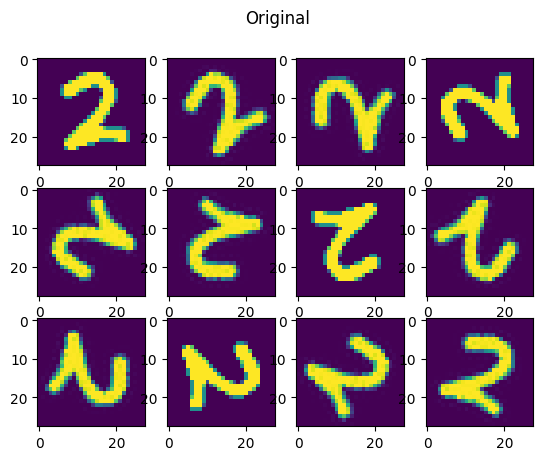

In [47]:
plt.suptitle("Original")
for i in range(len(test)):
    plt.subplot(3,4,i+1)
    plt.imshow(test[i])

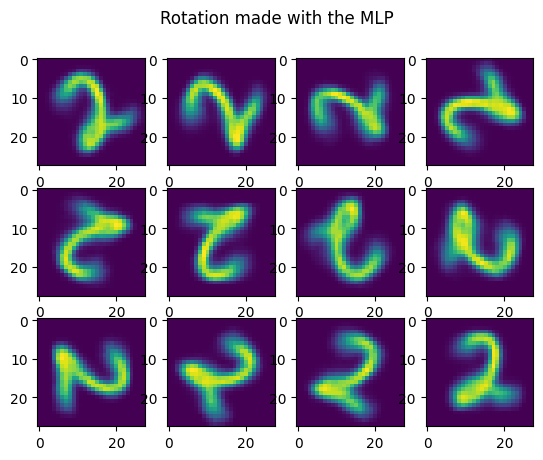

In [48]:
plt.suptitle("Rotation made with the MLP")
for i in range(len(test_rec)):
    plt.subplot(3,4,i+1)
    plt.imshow(test_rec[i])

# Task 3

In [49]:
# devo creare oracle che fa classification su tutto dataset (sono insicuro su questo pero se non fosse cosi oracle potrebbe sbagliare easy)
# poi introdurre generatori e fargli imparare le simmetrie come scritto sul paper su tutto dataset
#infine andare a printare come per task 2
#il succo e usare l'oracle per ricreare quello al task2 senza fare direttamente

In [5]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt
import scipy

# pytorch
import torch
import torchvision
import torchmetrics
from torchmetrics.classification import Accuracy

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.5.1+cu121
0.20.1+cu121


In [6]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [7]:
angles = np.arange(0, 360, 30)
angle_count = len(angles)

In [8]:
npzfile = np.load("/kaggle/working/latent_space.npz")
encoded_dataset = npzfile['encoded_dataset']
target_encoded = npzfile['target_encoded']
target_encoded = target_encoded - 1 # so we get class value [0,1]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(encoded_dataset, target_encoded, test_size=0.2, shuffle=True, random_state=12345)
X_train, X_vali, Y_train, Y_vali = train_test_split(X_train, Y_train, test_size=0.25, shuffle=True, random_state=12345)


print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

(8908, 12, 16)
(8908, 12)
(2970, 12, 16)
(2970, 12)
(2970, 12, 16)
(2970, 12)


In [10]:
from sklearn.preprocessing import StandardScaler
X_train = X_train.reshape((len(X_train)*12, 16))
X_vali = X_vali.reshape((len(X_vali)*12, 16))
X_test = X_test.reshape((len(X_test)*12, 16))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_vali = scaler.transform(X_vali)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((int(len(X_train)/12), 12, 16))
X_vali = X_vali.reshape((int(len(X_vali)/12), 12, 16))
X_test = X_test.reshape((int(len(X_test)/12), 12, 16))

In [11]:
X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).float()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).float()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).float()


batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt)
vali_dl = DataLoader(dataset_vali, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [12]:
class MLP_class(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLP_class, self).__init__()

    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, int(hidden_dim / 4))
    self.layer4 = nn.Linear(int(hidden_dim / 4), output_dim) #output layer

    self.relu = nn.ReLU() # relu function

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x)) 
    x = self.relu(self.layer3(x))
    out = torch.sigmoid(self.layer4(x))

    return out

In [13]:
oracle = MLP_class(input_dim=16, output_dim=1, hidden_dim=128)
oracle = oracle.to(device)
print(oracle)

from torchsummary import summary
if torch.cuda.is_available():
  summary(oracle.cuda(), input_size=(1,16))
else:
  summary(oracle, input_size=(1,16))

MLP_class(
  (layer1): Linear(in_features=16, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           2,176
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 32]           4,128
              ReLU-6                [-1, 1, 32]               0
            Linear-7                 [-1, 1, 1]              33
Total params: 22,849
Trainable params: 22,849
Non-trainable params: 0
----------------------------------------------------------------
Inp

In [14]:
criterion = nn.BCELoss()

metric = Accuracy(task="binary")
metric = metric.to(device)

from torch import optim
lr = 1.00e-5
opt = optim.Adam(oracle.parameters(), lr=lr)

# scheduler for step decay lr schedule
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=10)

In [15]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"Saving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
                }, 'best_oracle.pth')

In [16]:
import time

save_best_model = SaveBestModel() #initialize checkpoint function


epochs = 50
hist_loss = []
hist_vloss = []
hist_metric = []
hist_vmetric = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    oracle.train()
    train_loss = 0.
    vali_loss = 0.

    train_metric = 0.
    vali_metric = 0.
    
    counter = 0
    for xb, yb in train_dl:
        for i in range(angle_count):
            counter += 1
            x_rot = xb[:, i]
            y_rot = yb[:, i].unsqueeze(1)
        
            x_rot = x_rot.to(device)
            y_rot = y_rot.to(device)

            pred = oracle(x_rot)
            #if counter == 1:
                #print(pred[:10], y_rot[:10])
            loss = criterion(pred, y_rot)
            
            train_metric += metric(pred, y_rot).item()
            train_loss += loss.item()


            # backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()


    train_loss /= counter
    train_metric /= counter
    
    counter = 0
    oracle.eval()
    
    with torch.no_grad():
        for xb, yb in vali_dl:
            for i in range(angle_count):
                counter += 1
                x_rot = xb[:, i]
                y_rot = yb[:, i].unsqueeze(1)

                x_rot = x_rot.to(device)
                y_rot = y_rot.to(device)

                pred = oracle(x_rot)

                loss = criterion(pred, y_rot)

                vali_loss += loss.item()
                vali_metric += metric(pred, y_rot).item()

    
    vali_loss /= counter
    vali_metric /= counter

    hist_loss.append(train_loss)
    hist_vloss.append(vali_loss)
    hist_metric.append(train_metric)
    hist_vmetric.append(vali_metric)

    save_best_model(vali_loss, epoch, oracle, opt, criterion)

    current_lr = lr_scheduler.get_last_lr()[0]
    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.2f, tloss: %.3f, tmetric: %.3f, vloss: %.3f, vmetric: %.3f, lr: %1.2e" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))

    # update learning rate schedule
    lr_scheduler.step(vali_loss)


Best validation loss: 0.6922001443479372
Saving best model for epoch: 1

epoch: 1, time(s): 2.79, tloss: 0.692, tmetric: 0.530, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05

Best validation loss: 0.6921815407880838
Saving best model for epoch: 2

epoch: 2, time(s): 2.68, tloss: 0.692, tmetric: 0.529, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05
epoch: 3, time(s): 2.64, tloss: 0.691, tmetric: 0.529, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05
epoch: 4, time(s): 2.67, tloss: 0.691, tmetric: 0.530, vloss: 0.692, vmetric: 0.521, lr: 1.00e-05

Best validation loss: 0.6921422492334808
Saving best model for epoch: 5

epoch: 5, time(s): 2.69, tloss: 0.691, tmetric: 0.529, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05

Best validation loss: 0.6920807121888451
Saving best model for epoch: 6

epoch: 6, time(s): 2.77, tloss: 0.691, tmetric: 0.530, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05
epoch: 7, time(s): 2.67, tloss: 0.691, tmetric: 0.530, vloss: 0.692, vmetric: 0.521, lr: 1.00e-05
epoch: 8, time(s):

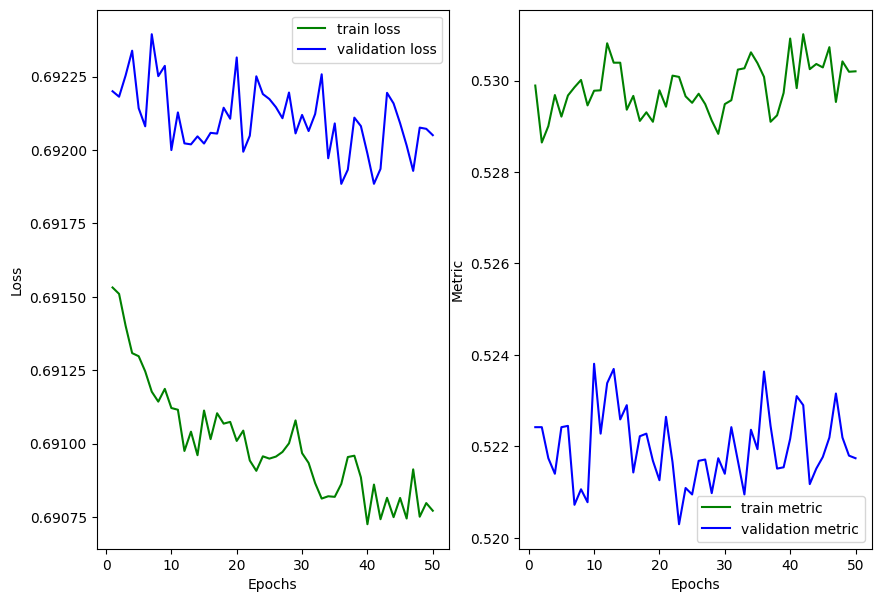

In [17]:
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [18]:
best_oracle = MLP_class(input_dim=16, output_dim=1, hidden_dim=128)
checkpoint = torch.load("best_oracle.pth", map_location=torch.device("cpu"), weights_only=False )
best_oracle.load_state_dict(checkpoint['model_state_dict'])
best_oracle.eval()

acc = Accuracy(task="binary")
criterion = nn.BCELoss()

loss = 0.
metric = 0.
counter = 0

with torch.no_grad():
  for xb, yb in test_dl:
    for i in range(angle_count):
        counter += 1
        x_rot = xb[:, i]
        y_rot = yb[:, i]
        y_rot = y_rot.unsqueeze(1)

        
        pred = best_oracle(x_rot)
        

        loss += criterion(pred, y_rot).item()
        metric += acc(pred, y_rot).item()

  loss /= counter
  metric /= (counter)

print('Test loss/accuracy oracle: ',loss, ' / ', metric)

Test loss/accuracy oracle:  0.690406141721684  /  0.5385246829710145


In [19]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLP, self).__init__()

    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, output_dim) #output layer

    self.relu = nn.ReLU() # relu function

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x) # oppure x = F.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    out = self.layer3(x)

    return out

In [29]:
generator = MLP(input_dim=16, output_dim=16, hidden_dim=128)
generator = generator.to(device)
print(generator)

from torchsummary import summary
if torch.cuda.is_available():
  summary(generator.cuda(), input_size=(1,16))
else:
  summary(generator, input_size=(1,16))

MLP(
  (layer1): Linear(in_features=16, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=16, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           2,176
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 16]           2,064
Total params: 20,752
Trainable params: 20,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [30]:
def invariance_loss(y_inf, y, epsilon = 1e-3):
    """
    Compute invariance loss from equation (10) in the paper
    """
                  
    # Calculate MSE scaled by epsilon^2
    loss = torch.mean((y_inf - y) ** 2) / (epsilon ** 2)
            
    return loss

In [31]:
def normalization_loss(genx):
    """
    Compute normalization loss from equation (11) in the paper
    """
            
    # Compute norm of each transformed vector
    norms = torch.norm(genx, dim=1)
            
    # First term: ensure norm is close to 1
    norm_deviation = torch.mean((norms - 1.0) ** 2)
            
    # Second term: ensure consistent norm across samples
    mean_norm = torch.mean(norms)
    norm_variance = torch.mean((norms - mean_norm) ** 2)
            
    loss = norm_deviation + norm_variance
            
    return loss

In [32]:
from torch import optim
lr = 0.001
opt = optim.Adam(generator.parameters(), lr=lr)

In [35]:
import time

#save_best_model = SaveBestModel() #initialize checkpoint function
epsilon = 1e-3

epochs = 50
hist_loss = []
#hist_vloss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    best_oracle.eval()
    train_loss = 0.
    vali_loss = 0.
    
    counter = 0
    for xb, yb in train_dl:
        for i in range(angle_count):
            counter += 1
            x_rot = xb[:, i]
            y_rot = yb[:, i].unsqueeze(1)
        
            x_rot = x_rot.to(device)
            y_rot = y_rot.to(device)
            
            genx = generator(x_rot)

            # Apply infinitesimal transformation
            x_inf = x_rot + epsilon * genx

            # Compute oracle output on transformed points
            y_inf = best_oracle(x_inf)

            inv_loss = invariance_loss(y_inf, y_rot, epsilon)

            norm_loss = normalization_loss(genx)

            loss = inv_loss + norm_loss
            
            train_loss += loss.item()


            # backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()


    train_loss /= counter
    """
    #counter = 0
    #oracle.eval()
    
    with torch.no_grad():
        for xb, yb in vali_dl:
            for i in range(angle_count):
                counter += 1
                x_rot = xb[:, i]
                y_rot = yb[:, i].unsqueeze(1)

                x_rot = x_rot.to(device)
                y_rot = y_rot.to(device)

                pred = oracle(x_rot)

                loss = criterion(pred, y_rot)

                vali_loss += loss.item()
                vali_metric += metric(pred, y_rot).item()

    
    vali_loss /= counter
    vali_metric /= counter
    """
    hist_loss.append(train_loss)
    #hist_vloss.append(vali_loss)

    #save_best_model(vali_loss, epoch, oracle, opt, criterion)

    current_lr = lr #lr_scheduler.get_last_lr()[0]
    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.2f, tloss: %.3f, vloss: %.3f, lr: %1.2e" 
          % (epoch+1, elapsed_time, train_loss, vali_loss, current_lr))

    # update learning rate schedule
    #lr_scheduler.step(vali_loss)

epoch: 1, time(s): 2.48, tloss: 248854.523, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 2, time(s): 2.41, tloss: 248874.811, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 3, time(s): 2.33, tloss: 248833.594, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 4, time(s): 2.48, tloss: 248877.444, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 5, time(s): 2.57, tloss: 248871.813, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 6, time(s): 2.38, tloss: 248852.235, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 7, time(s): 2.58, tloss: 248873.164, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 8, time(s): 2.49, tloss: 248822.759, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 9, time(s): 2.60, tloss: 248796.336, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 10, time(s): 2.48, tloss: 248860.940, tmetric: 0.530, vloss: 0.000

In [77]:

def visualize_latent_flow(generator, latent_vectors, decoder=None, steps=5, epsilon=0.01):
    with torch.no_grad():
        results = {
            'original_z': latent_vectors,
            'transformed_z': [],
            'decoded_images': [] if decoder else None
        }
        
        # For each starting point
        for z_start in latent_vectors:
            z_sequence = [z_start.clone()]
            z_current = z_start.clone()
            
            # Forward steps
            for _ in range(steps):
                delta_z = generator(z_current.unsqueeze(0)).squeeze(0)
                z_current = z_current + epsilon * delta_z
                z_sequence.append(z_current.clone())
                
            # Reset and do backward steps
            z_current = z_start.clone()
            for _ in range(steps):
                delta_z = generator(z_current.unsqueeze(0)).squeeze(0)
                z_current = z_current - epsilon * delta_z
                z_sequence.insert(0, z_current.clone())
                
            #results['transformed_z'].append(torch.stack(z_sequence))
            
            # Decode the transformed latent vectors if a decoder is provided
            if decoder and steps % 100 == 0:
                decoded_sequence = []
                for z in z_sequence:
                    decoded_img = decoder(z.unsqueeze(0))
                    decoded_sequence.append(decoded_img.squeeze(0))
                results['decoded_images'].append(torch.stack(decoded_sequence))
                
        return results

In [78]:
model_vae = VAE(encoder, decoder)
checkpoint = torch.load('./vae_model.pth', map_location=torch.device("cpu"), weights_only=False )
model_vae.load_state_dict(checkpoint['model_state_dict'])
model_vae.to("cpu")
model_vae.eval()

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=64, out_features=4096, bias=True)
    (fc2): Linear(in_features=32, out_features=64

In [105]:
results = visualize_latent_flow(generator, X_train_pt[1:2,0,], decoder=decoder, steps=, epsilon=0.01)

In [106]:
image = results['decoded_images'][0][::100,]
image.shape

torch.Size([21, 1, 28, 28])

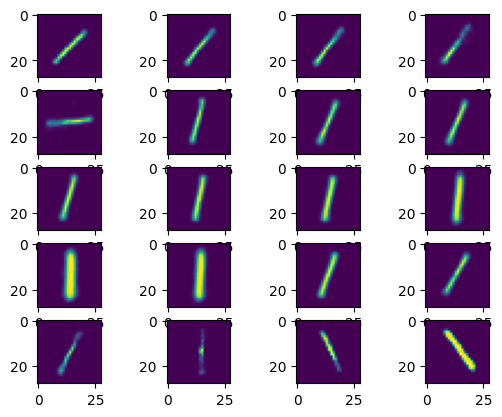

In [107]:
for i in range(len(image[:-1])):
    plt.subplot(5,4,i+1)
    plt.imshow(image[i].reshape((28,28)))

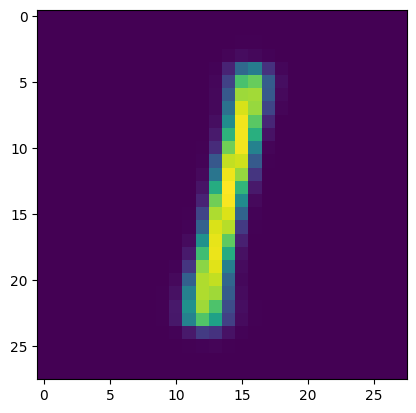

In [108]:
original = decoder(X_train_pt[1][0].unsqueeze(0)).detach().numpy()
plt.imshow(original.reshape((28,28)))